In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from natsort import natsorted, ns, natsort_keygen
import pandas as pd
import glob
import datetime
from datetime import timedelta
import scipy.fftpack
import pycwt as wavelet
import wavelets


In [2]:
def batch_delta_to_time(origin, x, time_format, delta_format):
    y = []
    for ix in x:
#         ix = np.asscalar(ix)
        if delta_format == "hours":
            temp_y = origin + timedelta(hours=ix)
        elif delta_format == "days":
            temp_y = origin + timedelta(days=ix)
        elif delta_format == "minutes":
            temp_y = origin + timedelta(minutes=ix)
        elif delta_format == "weeks":
            temp_y = origin + timedelta(weeks=ix)
        elif delta_format == "seconds":
            temp_y = origin + timedelta(seconds=ix)
        elif delta_format == "microseconds":
            temp_y = origin + timedelta(microseconds=ix)
        elif delta_format == "milliseconds":
            temp_y = origin + timedelta(milliseconds=ix)
        else:
            print("Sorry, this naive program only solve single time unit")
        y.append(temp_y.strftime(time_format))
    y = np.asarray(y)
#     y = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in y]
    return(y)

## I/O files

In [3]:
data_dir = "/global/project/projectdirs/m1800/pin/Reach_scale_model/data/"
fname_river_bc = "/global/project/projectdirs/m1800/pin/Reach_scale_model/Inputs/river_bc/bc_6h_smooth_032807/"
fname_river_bc_1w = "/global/project/projectdirs/m1800/pin/Reach_scale_model/Inputs/river_bc/bc_1w_smooth_032807/"

fname_mass1 = data_dir + "MASS1/transient_1976_2016/"

fig_river_stage = "/global/project/projectdirs/m1800/pin/Reach_scale_model/Outputs/river_stage/snapshots/"
fig_river_stage_6h = "/global/project/projectdirs/m1800/pin/Reach_scale_model/Outputs/river_stage_6h/"
fig_river_stage_120h = "/global/project/projectdirs/m1800/pin/Reach_scale_model/Outputs/river_stage_120h/"

In [4]:
start_time = datetime.datetime.strptime("2007-03-28 12:00:00", "%Y-%m-%d %H:%M:%S")
date_origin = start_time

time_ticks = [
    "2011-01-01 00:00:00",
    "2012-01-01 00:00:00",
    "2013-01-01 00:00:00",
    "2014-01-01 00:00:00",
    "2015-01-01 00:00:00",
    "2016-01-01 00:00:00"]
time_ticks = [datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in time_ticks]

selected_ticks = [
    "2012-02-25 00:00:00",
    "2012-04-30 00:00:00",
    "2012-07-04 00:00:00",
    "2012-08-18 00:00:00",
    "2012-10-17 00:00:00"
    ]
selected_ticks = [datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in selected_ticks]

# plot 6h-smoothed river stage

## import river stage

In [5]:
datum_files = glob.glob(fname_river_bc + "Datum*.txt")

datum_files = natsorted(datum_files) # sort files naturally, i.e. 1, 2, 11, 22, ...

In [6]:
river_north_datum = pd.read_table(datum_files[0], sep=' ', header=None, names=['time', 'x', 'y', 'wl'])
river_middle_datum = pd.read_table(datum_files[(len(datum_files)-1)//2], sep=' ', header=None, names=['time', 'x', 'y', 'wl'])
river_south_datum = pd.read_table(datum_files[-1], sep=' ', header=None, names=['time', 'x', 'y', 'wl'])

river_north_datum['time'] = batch_delta_to_time(date_origin, river_north_datum['time'], "%Y-%m-%d %H:%M:%S", "seconds")
river_middle_datum['time'] = batch_delta_to_time(date_origin, river_middle_datum['time'], "%Y-%m-%d %H:%M:%S", "seconds")
river_south_datum['time'] = batch_delta_to_time(date_origin, river_south_datum['time'], "%Y-%m-%d %H:%M:%S", "seconds")

In [7]:
river_north_datum['time'] = river_north_datum['time'].apply(pd.to_datetime)
river_middle_datum['time'] = river_middle_datum['time'].apply(pd.to_datetime)
river_south_datum['time'] = river_south_datum['time'].apply(pd.to_datetime)

## plot river stage

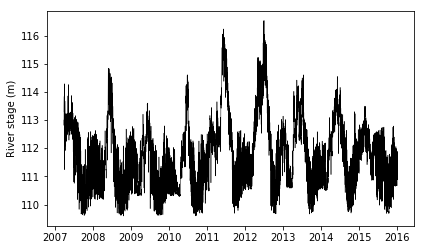

In [11]:
fig, ax1 = plt.subplots(1, 1)

# river_north_datum.plot(x='time', y='wl',color= 'black', linewidth = 0.5, ax=ax1, legend=None)
river_middle_datum.plot(x='time', y='wl',color= 'black',linewidth = 0.5, ax=ax1, legend=None)
# river_south_datum.plot(x='time', y='wl',color= 'black', linewidth = 0.5, ax=ax1, legend=None)

ax1.set_ylabel('River stage (m)')
ax1.set_xlabel('')
# ax1.set_title('River stage from upstream to downstream')
# ax1.set_aspect("equal", "datalim")
ax1.xaxis.set_major_locator(mdates.YearLocator())
# ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax1.xaxis.set_tick_params('labelbottom')

# ax1.set_xlim([time_ticks[0], time_ticks[-1]])
plt.setp( ax1.xaxis.get_majorticklabels(), rotation=0, ha = 'center' )

# ax1.legend(handles=legend_elements, loc='best')
fig.tight_layout()
fig.set_size_inches(6, 3.5)

In [ ]:
fig.savefig(fig_river_stage + 'river_stage_m_2011_2016.jpg', dpi=300)
plt.close(fig)

## plot river stage with moving-label

In [8]:
# tick_start = datetime.datetime.strptime("2011-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
# tick_end = datetime.datetime.strptime("2016-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")

times = pd.date_range(start = '1/1/2011', end = '1/1/2016', freq = '5D') 
# times = pd.date_range(start = '1/1/2011', end = '1/1/2016', freq = '6H') 

In [10]:
ct = 0
for itime in times[:]:
    print(itime)
    ct += 1
    fig, ax1 = plt.subplots(1, 1)

    # river_north_datum.plot(x='time', y='wl',color= 'black', linewidth = 0.5, ax=ax1, legend=None)
    river_middle_datum.plot(x='time', y='wl',color= 'black',linewidth = 0.5, ax=ax1, legend=None)
    # river_south_datum.plot(x='time', y='wl',color= 'black', linewidth = 0.5, ax=ax1, legend=None)

    # add moving time tick
    ax1.plot((itime, itime), (100, 120), 'r-')


    ax1.set_ylabel('River stage (m)')
    ax1.set_xlabel('')
    ax1.set_title(itime, fontsize = 14)
    # ax1.set_aspect("equal", "datalim")
    
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax1.xaxis.set_tick_params('labelbottom')

    ax1.set_xlim([time_ticks[0], time_ticks[-1]])
    ax1.set_ylim([109, 117])
    plt.setp( ax1.xaxis.get_majorticklabels(), rotation=0, ha = 'center' )

    # ax1.legend(handles=legend_elements, loc='best')
    fig.tight_layout()
    fig.set_size_inches(6, 3.5)

    fig.savefig(fig_river_stage_120h + 'stage_{:04d}.jpg'.format(ct), dpi=300)
    plt.close(fig)

2011-01-01 00:00:00
2011-01-06 00:00:00
2011-01-11 00:00:00
2011-01-16 00:00:00
2011-01-21 00:00:00
2011-01-26 00:00:00
2011-01-31 00:00:00
2011-02-05 00:00:00
2011-02-10 00:00:00
2011-02-15 00:00:00
2011-02-20 00:00:00
2011-02-25 00:00:00
2011-03-02 00:00:00
2011-03-07 00:00:00
2011-03-12 00:00:00
2011-03-17 00:00:00
2011-03-22 00:00:00
2011-03-27 00:00:00
2011-04-01 00:00:00
2011-04-06 00:00:00
2011-04-11 00:00:00
2011-04-16 00:00:00
2011-04-21 00:00:00
2011-04-26 00:00:00
2011-05-01 00:00:00
2011-05-06 00:00:00
2011-05-11 00:00:00
2011-05-16 00:00:00
2011-05-21 00:00:00
2011-05-26 00:00:00
2011-05-31 00:00:00
2011-06-05 00:00:00
2011-06-10 00:00:00
2011-06-15 00:00:00
2011-06-20 00:00:00
2011-06-25 00:00:00
2011-06-30 00:00:00
2011-07-05 00:00:00
2011-07-10 00:00:00
2011-07-15 00:00:00
2011-07-20 00:00:00
2011-07-25 00:00:00
2011-07-30 00:00:00
2011-08-04 00:00:00
2011-08-09 00:00:00
2011-08-14 00:00:00
2011-08-19 00:00:00
2011-08-24 00:00:00
2011-08-29 00:00:00
2011-09-03 00:00:00


**plot river stage for individual year**

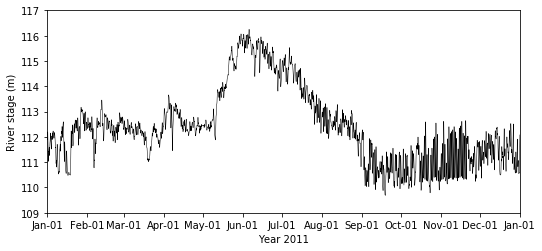

In [60]:
fig, ax1 = plt.subplots(1, 1)

# river_north_datum.plot(x='time', y='wl',color= 'black', linewidth = 0.5, ax=ax1, legend=None)
river_middle_datum.plot(x='time', y='wl',color= 'black',linewidth = 0.5, ax=ax1, legend=None)
# river_south_datum.plot(x='time', y='wl',color= 'black', linewidth = 0.5, ax=ax1, legend=None)

## add line for selected time
for itime in selected_ticks:
    x = [itime, itime]
    y = [0, 200]
    ax1.plot(x, y, 'r-')

ax1.set_ylabel('River stage (m)')
ax1.set_xlabel('Year 2011')
# ax1.set_title('River stage from upstream to downstream')
# ax1.set_aspect("equal", "datalim")
# ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_locator(mdates.MonthLocator())
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax1.xaxis.set_tick_params('labelbottom')

ax1.set_ylim([109, 117])
ax1.set_xlim([time_ticks[0], time_ticks[1]])
plt.setp( ax1.xaxis.get_majorticklabels(), rotation=0, ha = 'center' )

# ax1.legend(handles=legend_elements, loc='best')
fig.tight_layout()
fig.set_size_inches(8, 3.5)

In [62]:
fig.savefig(fig_river_stage+ 'river_stage_2011.jpg', dpi=300)
plt.close(fig)

# plot 1w-smoothed river stage

In [14]:
datum_files = glob.glob(fname_river_bc_1w + "Datum*.txt")
datum_files = natsorted(datum_files) # sort files naturally, i.e. 1, 2, 11, 22, ...

In [22]:
river_north_datum_s = pd.read_table(datum_files[0], sep=' ', header=None, names=['time', 'x', 'y', 'wl'])
river_middle_datum_s = pd.read_table(datum_files[(len(datum_files)-1)//2], sep=' ', header=None, names=['time', 'x', 'y', 'wl'])
river_south_datum_s = pd.read_table(datum_files[-1], sep=' ', header=None, names=['time', 'x', 'y', 'wl'])

river_north_datum_s.time = batch_delta_to_time(date_origin, river_north_datum_s.time, "%Y-%m-%d %H:%M:%S", "seconds")
river_middle_datum_s.time = batch_delta_to_time(date_origin, river_middle_datum_s.time, "%Y-%m-%d %H:%M:%S", "seconds")
river_south_datum_s.time = batch_delta_to_time(date_origin, river_south_datum_s.time, "%Y-%m-%d %H:%M:%S", "seconds")


In [23]:
river_north_datum_s['time'] = river_north_datum_s['time'].apply(pd.to_datetime)
river_middle_datum_s['time'] = river_middle_datum_s['time'].apply(pd.to_datetime)
river_south_datum_s['time'] = river_south_datum_s['time'].apply(pd.to_datetime)

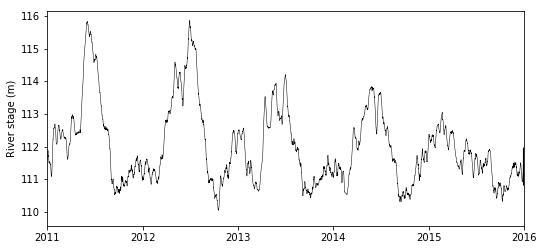

In [24]:
fig, ax1 = plt.subplots(1, 1)

# river_north_datum_s.plot(x='time', y='wl',color= 'black', linewidth = 0.5, ax=ax1, legend=None)
river_middle_datum_s.plot(x='time', y='wl',color= 'black',linewidth = 0.5, ax=ax1, legend=None)
# river_south_datum_s.plot(x='time', y='wl',color= 'black', linewidth = 0.5, ax=ax1, legend=None)

ax1.set_ylabel('River stage (m)')
ax1.set_xlabel('')
# ax1.set_title('River stage from upstream to downstream')
# ax1.set_aspect("equal", "datalim")
ax1.xaxis.set_major_locator(mdates.YearLocator())
# ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax1.xaxis.set_tick_params('labelbottom')

ax1.set_xlim([time_ticks[0], time_ticks[-1]])
plt.setp( ax1.xaxis.get_majorticklabels(), rotation=0, ha = 'center' )

# ax1.legend(handles=legend_elements, loc='best')
fig.tight_layout()
fig.set_size_inches(8, 3.5)

In [ ]:
fig.savefig(fig_river_stage+'river_stage_m_2011_2016_s.jpg', dpi=300)
plt.close(fig)

# plot all stages

Mass1 points (40, 186, 332) are used as upstream, middle and downstream river stage.

In [12]:
mass1_files = glob.glob(fname_mass1 + "mass1_*.csv")
mass1_files = natsorted(mass1_files) # sort files naturally, i.e. 1, 2, 11, 22, ...

In [15]:
mass1_up = pd.read_csv(mass1_files[0], index_col = None, usecols = ['date','stage'],
                       na_filter = False, parse_dates = ['date'])
mass1_mid = pd.read_csv(mass1_files[(len(mass1_files)-1)//2], index_col = None, usecols = ['date','stage'],
                       na_filter = False, parse_dates = ['date'])
mass1_down = pd.read_csv(mass1_files[-1], index_col = None, usecols = ['date','stage'],
                       na_filter = False, parse_dates = ['date'])

add 1.039 to mass1 datum for corection

In [16]:
mass1_up['stage'] = mass1_up['stage'] + 1.039
mass1_mid['stage'] = mass1_mid['stage'] + 1.039
mass1_down['stage'] = mass1_down['stage'] + 1.039

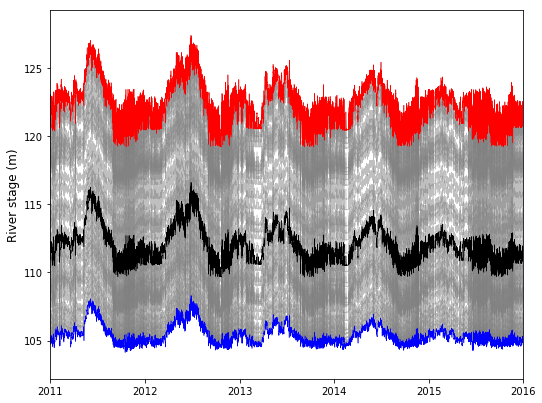

In [68]:
fig, ax1 = plt.subplots(1, 1)


for ifile in mass1_files[::10]:
    imass1 = pd.read_csv(ifile, index_col = None, usecols = ['date','stage'],
                       na_filter = False, parse_dates = ['date'])
    imass1['stage'] = imass1['stage'] + 1.039
    imass1.plot(x='date', y='stage',color= 'gray',linewidth = 0.5, ax=ax1, legend=None, alpha = 0.5)

mass1_up.plot(x='date', y='stage',color= 'red',linewidth = 0.5, ax=ax1, legend=None)
mass1_mid.plot(x='date', y='stage',color= 'black',linewidth = 0.5, ax=ax1, legend=None)
mass1_down.plot(x='date', y='stage',color= 'blue',linewidth = 0.5, ax=ax1, legend=None)

ax1.set_ylabel('River stage (m)', fontsize = 12)
ax1.set_xlabel('')

ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_tick_params('labelbottom')

ax1.set_xlim([time_ticks[0], time_ticks[-1]])

ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)

plt.setp( ax1.xaxis.get_majorticklabels(), rotation=0, ha = 'center' )

# ax1.legend(handles=legend_elements, loc='best')
fig.tight_layout()
fig.set_size_inches(8, 6)

In [69]:
fig.savefig(fig_river_stage+'river_stage_all.png', dpi=300, transparent = True)
plt.close(fig)

# Spectral analysis using FFT

/global/homes/p/pshuai/.conda/envs/nersc/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


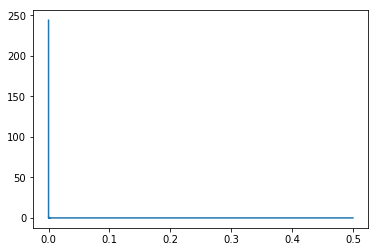

In [21]:
# Number of samplepoints
N = len(river_north_datum.wl)
# sample spacing
T = 1.0 # hour
x = np.linspace(0.0, N*T, N)
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
y = river_north_datum['wl'].values
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))

# Wavelet analysis

In [60]:
# given a signal x(t)
# x = np.random.randn(1000)
dat = river_north_datum.wl
# and a sample spacing
t0 = 0
dt = 1 # in hours

N = dat.size
t = np.arange(0, N) * dt + t0

std = dat.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat / std  # Normalized dataset

In [61]:
mother = wavelet.Morlet(6)
s0 = -1  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 0.25  # Twelve sub-octaves per octaves
J = -1  # Seven powers of two with dj sub-octaves
# alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

In [62]:
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

In [63]:
power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

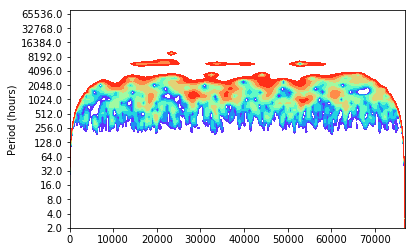

In [82]:
fig, bx = plt.subplots(1,1)

levels = [1, 2, 4, 8, 16, 32,64,128,256]

bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
             cmap=pyplot.cm.rainbow)

# extent = [t.min(), t.max(), 0, max(period)]
# bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#            extent=extent)
# bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
#                            t[:1] - dt, t[:1] - dt]),
#         np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
#                            np.log2(period[-1:]), [1e-9]]),
#         'k', alpha=0.3, hatch='x')
# bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (hours)')
#
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                           np.ceil(np.log2(period.max())))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)

## An example by PyCWT


[link](https://pycwt.readthedocs.io/en/latest/tutorial.html#time-series-spectral-analysis-using-wavelets)

In [28]:
"""
In this example we will load the NINO3 sea surface temperature anomaly dataset
between 1871 and 1996. This and other sample data files are kindly provided by
C. Torrence and G. Compo at
<http://paos.colorado.edu/research/wavelets/software.html>.

"""
# We begin by importing the relevant libraries. Please make sure that PyCWT is
# properly installed in your system.
from __future__ import division
# import numpy
from matplotlib import pyplot

# import pycwt as wavelet
from pycwt.helpers import find

In [55]:
# Then, we load the dataset and define some data related parameters. In this
# case, the first 19 lines of the data file contain meta-data, that we ignore,
# since we set them manually (*i.e.* title, units).
url = 'http://paos.colorado.edu/research/wavelets/wave_idl/nino3sst.txt'
dat = np.genfromtxt(url, skip_header=19)
title = 'NINO3 Sea Surface Temperature'
label = 'NINO3 SST'
units = 'degC'
t0 = 1871.0
dt = 0.25  # In years

# We also create a time array in years.
N = dat.size
t = np.arange(0, N) * dt + t0

# We write the following code to detrend and normalize the input data by its
# standard deviation. Sometimes detrending is not necessary and simply
# removing the mean value is good enough. However, if your dataset has a well
# defined trend, such as the Mauna Loa CO\ :sub:`2` dataset available in the
# above mentioned website, it is strongly advised to perform detrending.
# Here, we fit a one-degree polynomial function and then subtract it from the
# original data.
p = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - np.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset

# The next step is to define some parameters of our wavelet analysis. We
# select the mother wavelet, in this case the Morlet wavelet with
# :math:`\omega_0=6`.
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

# The following routines perform the wavelet transform and inverse wavelet
# transform using the parameters defined above. Since we have normalized our
# input time-series, we multiply the inverse transform by the standard
# deviation.
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

# We calculate the normalized wavelet and Fourier power spectra, as well as
# the Fourier equivalent periods for each wavelet scale.
power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

# We could stop at this point and plot our results. However we are also
# interested in the power spectra significance test. The power is significant
# where the ratio ``power / sig95 > 1``.
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

# Then, we calculate the global wavelet spectrum and determine its
# significance level.
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

# We also calculate the scale average between 2 years and 8 years, and its
# significance level.
sel = find((period >= 2) & (period < 8))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

/global/homes/p/pshuai/.conda/envs/nersc/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


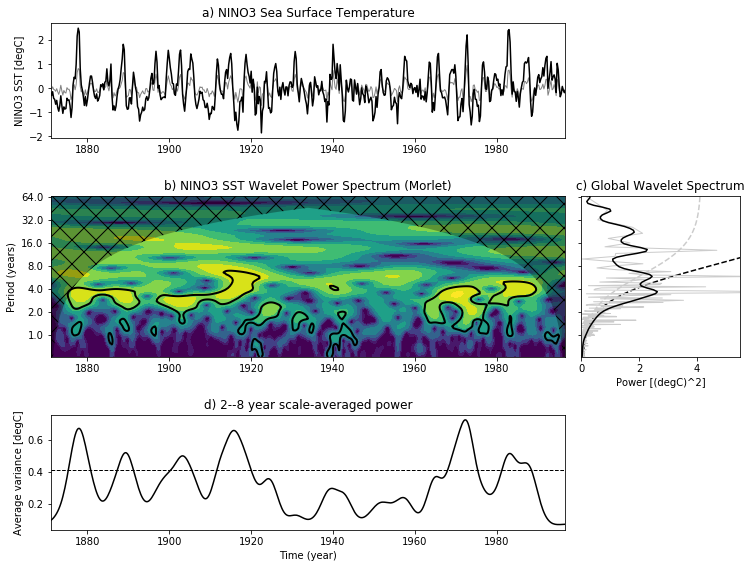

In [56]:
# Finally, we plot our results in four different subplots containing the
# (i) original series anomaly and the inverse wavelet transform; (ii) the
# wavelet power spectrum (iii) the global wavelet and Fourier spectra ; and
# (iv) the range averaged wavelet spectrum. In all sub-plots the significance
# levels are either included as dotted lines or as filled contour lines.

# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                           np.ceil(np.log2(period.max())))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, np.log2(period), 'k--')
cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

pyplot.show()